### Dependencies

In [1]:
import os, sys, logging
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import tensorflow as tf

from time import sleep
from timeit import default_timer

import matplotlib.pyplot as plt
from pdb import set_trace as bp

In [2]:
# Relative imports
sys.path.insert(0, os.path.join(sys.path[0], '..'))
import src, tasks
from helpers import plotting

### Notebook settings

In [3]:
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
plt.rc('figure', dpi=256)

np.set_printoptions(precision=3)
tf.logging.set_verbosity('ERROR')

In [4]:
# Ensure dictionaries are ordered
from sys import version_info
if (version_info.major + 0.1 * version_info.minor < 3.6):
    from collections import OrderedDict as dict

In [5]:
# Setup logging
logger = logging.getLogger('run_bayesopt')
logging.basicConfig(
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    format='%(asctime)-4s %(levelname)s:%(name)s:%(message)s')

### Bayesian optimization simulator

In [6]:
def run_simulation(sess, agent, task, inputs_old, outputs_old, job_limit=16, 
    parallelism=2, asynchronous=True, visualize=True):
    '''
    Immitate real-world usage case.
    '''     
    # Preallocate local objects
    answer = None #if we stopped immediately, what conclusion would be draw about optimal input?
    deadlines = np.empty([0], dtype=task.dtype) #when pending jobs will finish
    inputs_pend = np.empty([0, inputs_old.shape[-1]], dtype=task.dtype) #what jobs are currently running?
    current_time = np.zeros([1]) #simulation time

    # Iterate until job budget has been exhausted
    while len(inputs_old) < job_limit:
        # Check if any pending jobs have finished
        finished = deadlines <= current_time
        if np.any(finished):
            logger.info('{:d} job(s) finished'.format(np.sum(finished)))

            # Evaluate 'finshed' jobs
            X = inputs_pend[finished]
            Y = task.numpy(X)
            
            # Update old/pending job info
            inputs_old = np.vstack([inputs_old, X])
            outputs_old = np.vstack([outputs_old, Y])
            unfinished = np.logical_not(finished)
            inputs_pend = inputs_pend[unfinished]
            deadlines = deadlines[unfinished]
                
            logger.info('Updating search agent')
            _ = agent.update(sess, inputs_old, outputs_old)

            logger.info('Requesting updated answer')
            answer, expectation = agent.suggest_answers\
            (
                num_suggest=1,
                inputs_old=inputs_old,
                outputs_old=outputs_old,
                sess=sess,
            )
            
            # Report how well we're actually doing (not used elswhere)
            ground_truth = np.squeeze(task.numpy(answer, noisy=False))
            logger.info('Agent recommended f(x*={})={:.3e}'.format(answer, ground_truth))
        
        # If any workers are free, get new jobs for them
        num_pending = len(inputs_pend)
        num_suggest = min(parallelism - num_pending, job_limit - len(inputs_old) - num_pending)
        if (num_suggest > 0):
            logger.info('Requesting {:d} job suggestion(s)'.format(num_suggest))
            suggestions, loss = agent.suggest_inputs\
            (
                num_suggest=num_suggest,
                inputs_old=inputs_old,
                outputs_old=outputs_old,
                inputs_pend=inputs_pend,
                sess=sess,
                time_limit=10, #how much time is the agent allowed to spend deliberating?
            )
            
            # Visualize current state of optimization episode
            if visualize:
                if parallelism == 2: fig = plt.figure(figsize=(12, 5))
                else: fig = plt.figure(figsize=(12, 8))
                _ = plotting.plot_state(agent, sess, inputs_old,outputs_old, inputs_pend, 
                                        answer=answer, query=suggestions, task=task,
                                        fig=fig, show_acquisition=parallelism < 3)
                plt.show()
                

            # 'Schedule' new jobs
            inputs_pend = np.vstack([inputs_pend, suggestions])
            if not asynchronous: runtimes = np.ones(num_suggest)
            else: runtimes = rng.exponential(1, num_suggest)
            deadlines = np.hstack([deadlines, current_time + runtimes])


        # Determine how far ahead in time to advance the simulation
        num_pend = len(inputs_pend)
        num_jobs = num_pend + len(inputs_old)
        can_request = (num_jobs < job_limit) and (num_pend < parallelism) #can new jobs be scheduled immediately?
        if not can_request:
            # If asynchronous, randomize num. arrivals at next iteration
            tic = rng.exponential(0.5) if asynchronous else 1
            current_time += tic


    # Visualize final state of optimization episode
    if visualize:
        if parallelism == 2: fig = plt.figure(figsize=(12, 5))
        else: fig = plt.figure(figsize=(12, 8))
        _ = plotting.plot_state(agent, sess, inputs_old,outputs_old,
                                answer=answer, query=suggestions, task=task,
                                fig=fig, show_acquisition=parallelism < 3)
        plt.show()

    logger.info('Finished optimization episode.')
    return inputs_old, outputs_old

### Initialization

In [7]:
sess = tf.InteractiveSession()
seed = npr.choice(2**31 - 1)
tf.set_random_seed(seed)
rng = npr.RandomState(seed)
logger.info('pRNG seed: {:d}'.format(seed))

2018-11-27 14:17:05 INFO:run_bayesopt:pRNG seed: 1546923484


In [8]:
# Black-box optimization task
task = tasks.univariate05(noise=1e-3)

# Initialize surrogate model
model = src.models.gaussian_process(name='gp')
params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='gp')
sess.run(tf.variables_initializer(params))

# Establish loss function (negative expected utility)
loss_fn=src.losses.negative_ei(cache_rvs=True) #save r.v.'s for reuse when plotting

# Create search agent
agent = src.agents.bayesian_optimization\
(
    loss_fn=loss_fn,
    model=model,
    name='bayesopt',
    dtype=model.dtype,
    num_options=2**10, #num. initial points to consider when optimizing acq. function
    seed=seed,
)

### Run simulation

2018-11-27 14:17:05 INFO:run_bayesopt:Updating search agent
2018-11-27 14:17:06 INFO:src.agents.bayesian_optimization:Fit model in 7.18e-01s
2018-11-27 14:17:06 INFO:src.agents.bayesian_optimization:Updated model vars: [0.914, -4.605, -1.068, -352.916]
2018-11-27 14:17:06 INFO:src.agents.bayesian_optimization:Updated loss function in 6.47e-06s
2018-11-27 14:17:06 INFO:run_bayesopt:Requesting 2 job suggestion(s)
2018-11-27 14:17:08 INFO:src.agents.bayesian_optimization:Evaluated 207360 marginal losses in 1.008e+00s
2018-11-27 14:17:17 INFO:src.agents.bayesian_optimization:SGD evaluated 3776 losses in 7.786e+00s


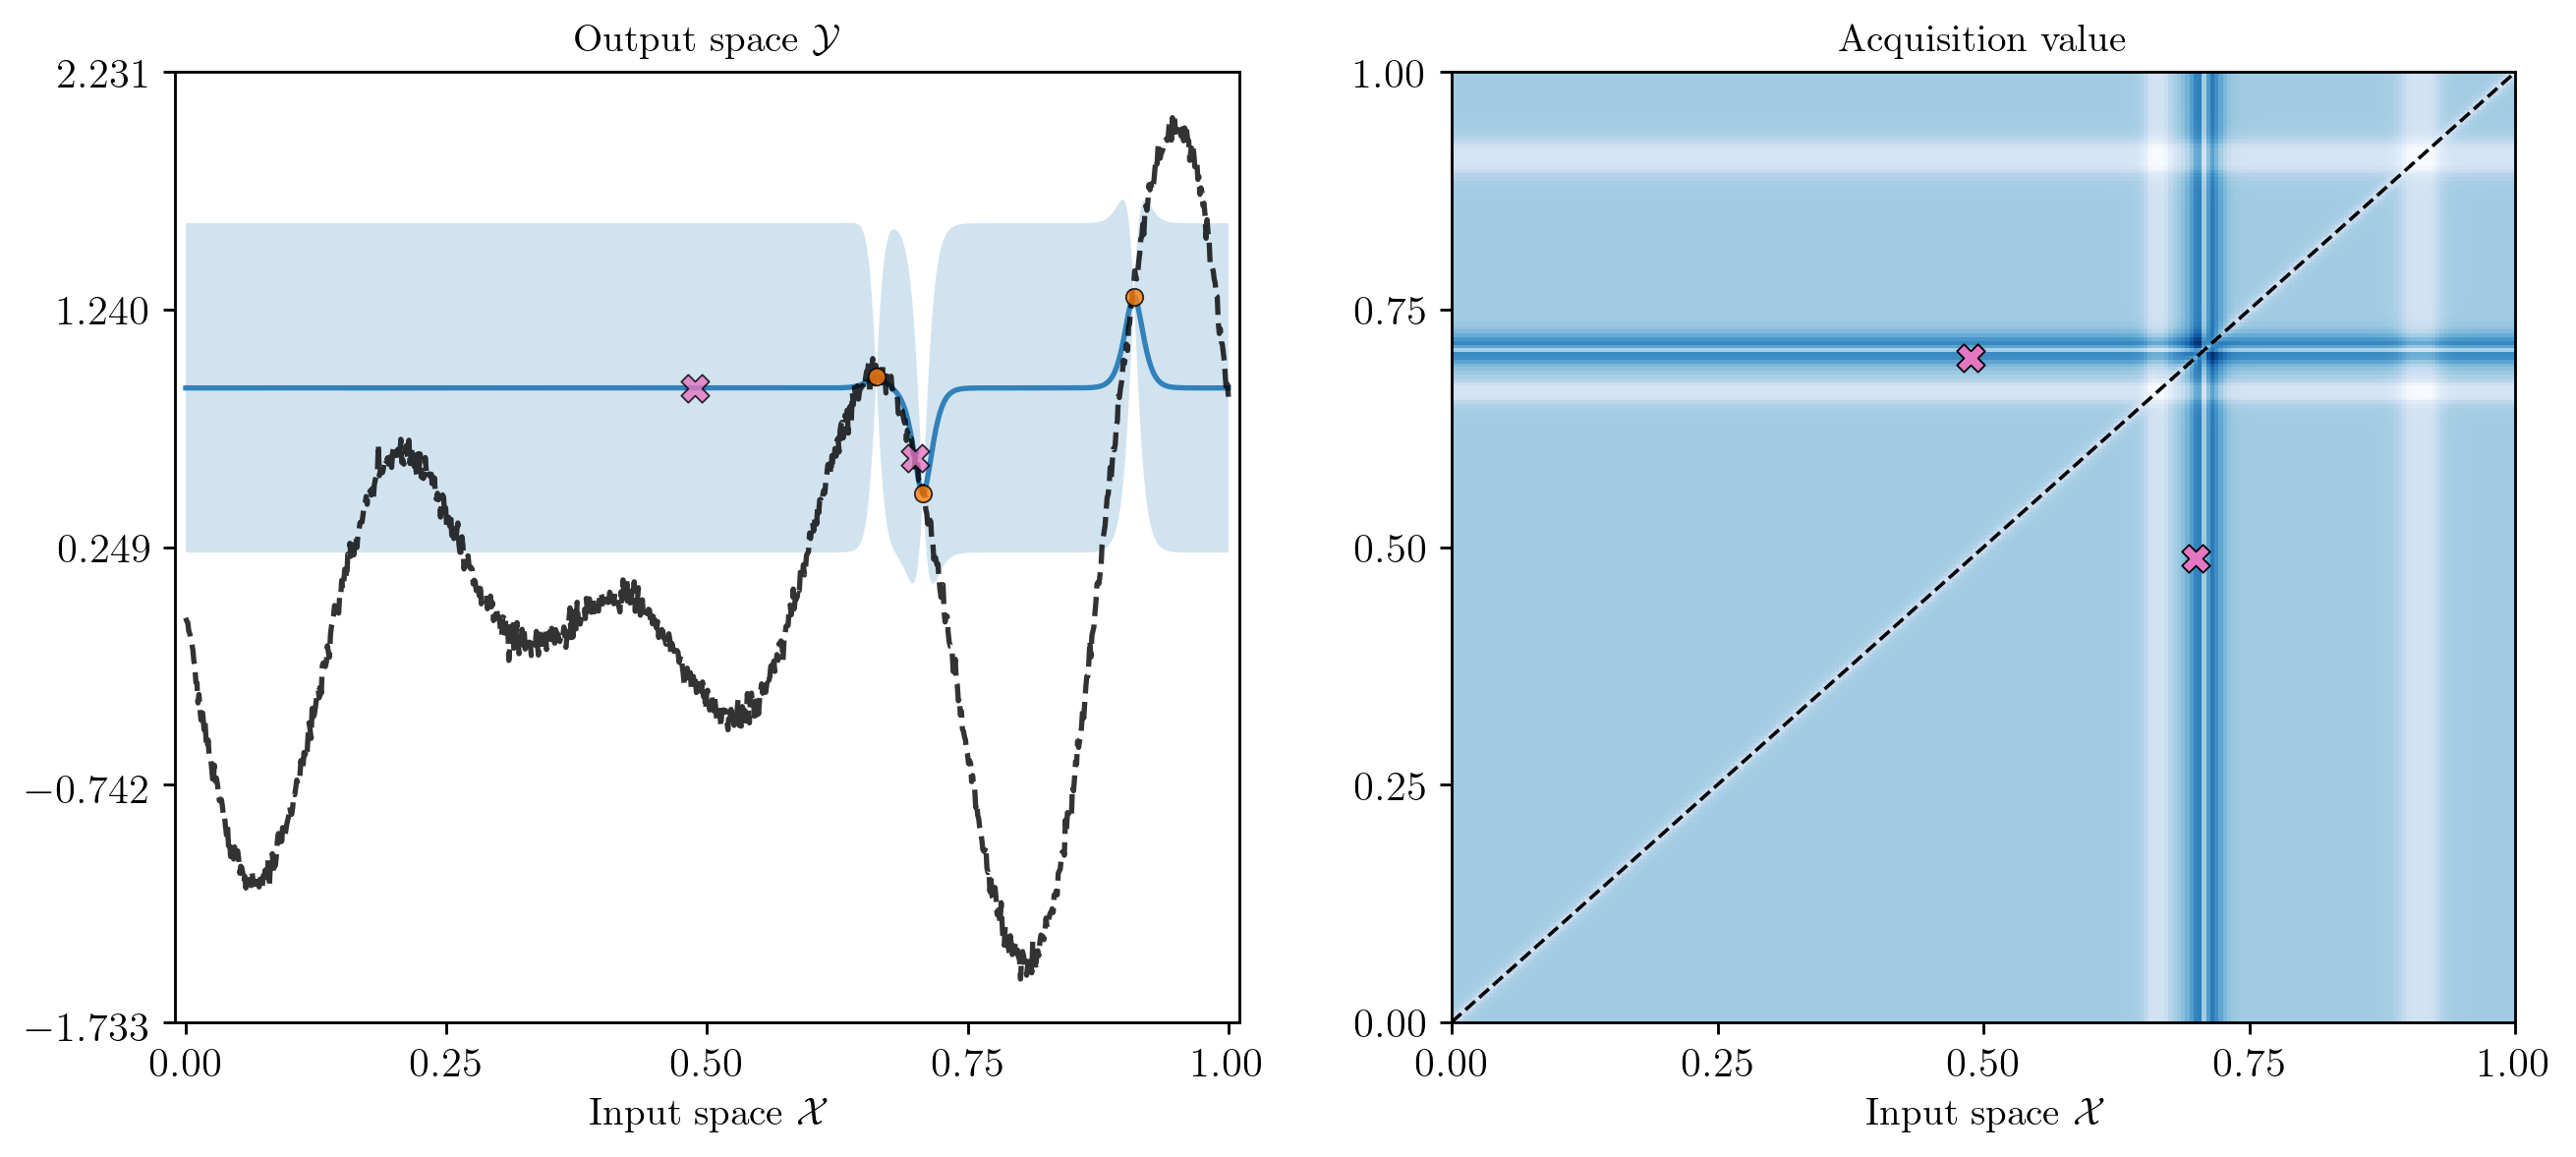

2018-11-27 14:17:24 INFO:run_bayesopt:2 job(s) finished
2018-11-27 14:17:24 INFO:run_bayesopt:Updating search agent
2018-11-27 14:17:25 INFO:src.agents.bayesian_optimization:Fit model in 8.55e-01s
2018-11-27 14:17:25 INFO:src.agents.bayesian_optimization:Updated model vars: [0.56, -3.43, -0.542, -352.832]
2018-11-27 14:17:25 INFO:src.agents.bayesian_optimization:Updated loss function in 1.30e-05s
2018-11-27 14:17:25 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:17:28 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 1136640 losses in 1.970e+00s
2018-11-27 14:17:28 INFO:run_bayesopt:Agent recommended f(x*=[[0.488]])=-3.217e-01
2018-11-27 14:17:28 INFO:run_bayesopt:Requesting 2 job suggestion(s)
2018-11-27 14:17:29 INFO:src.agents.bayesian_optimization:Evaluated 230400 marginal losses in 1.003e+00s
2018-11-27 14:17:38 INFO:src.agents.bayesian_optimization:SGD evaluated 2848 losses in 8.898e+00s


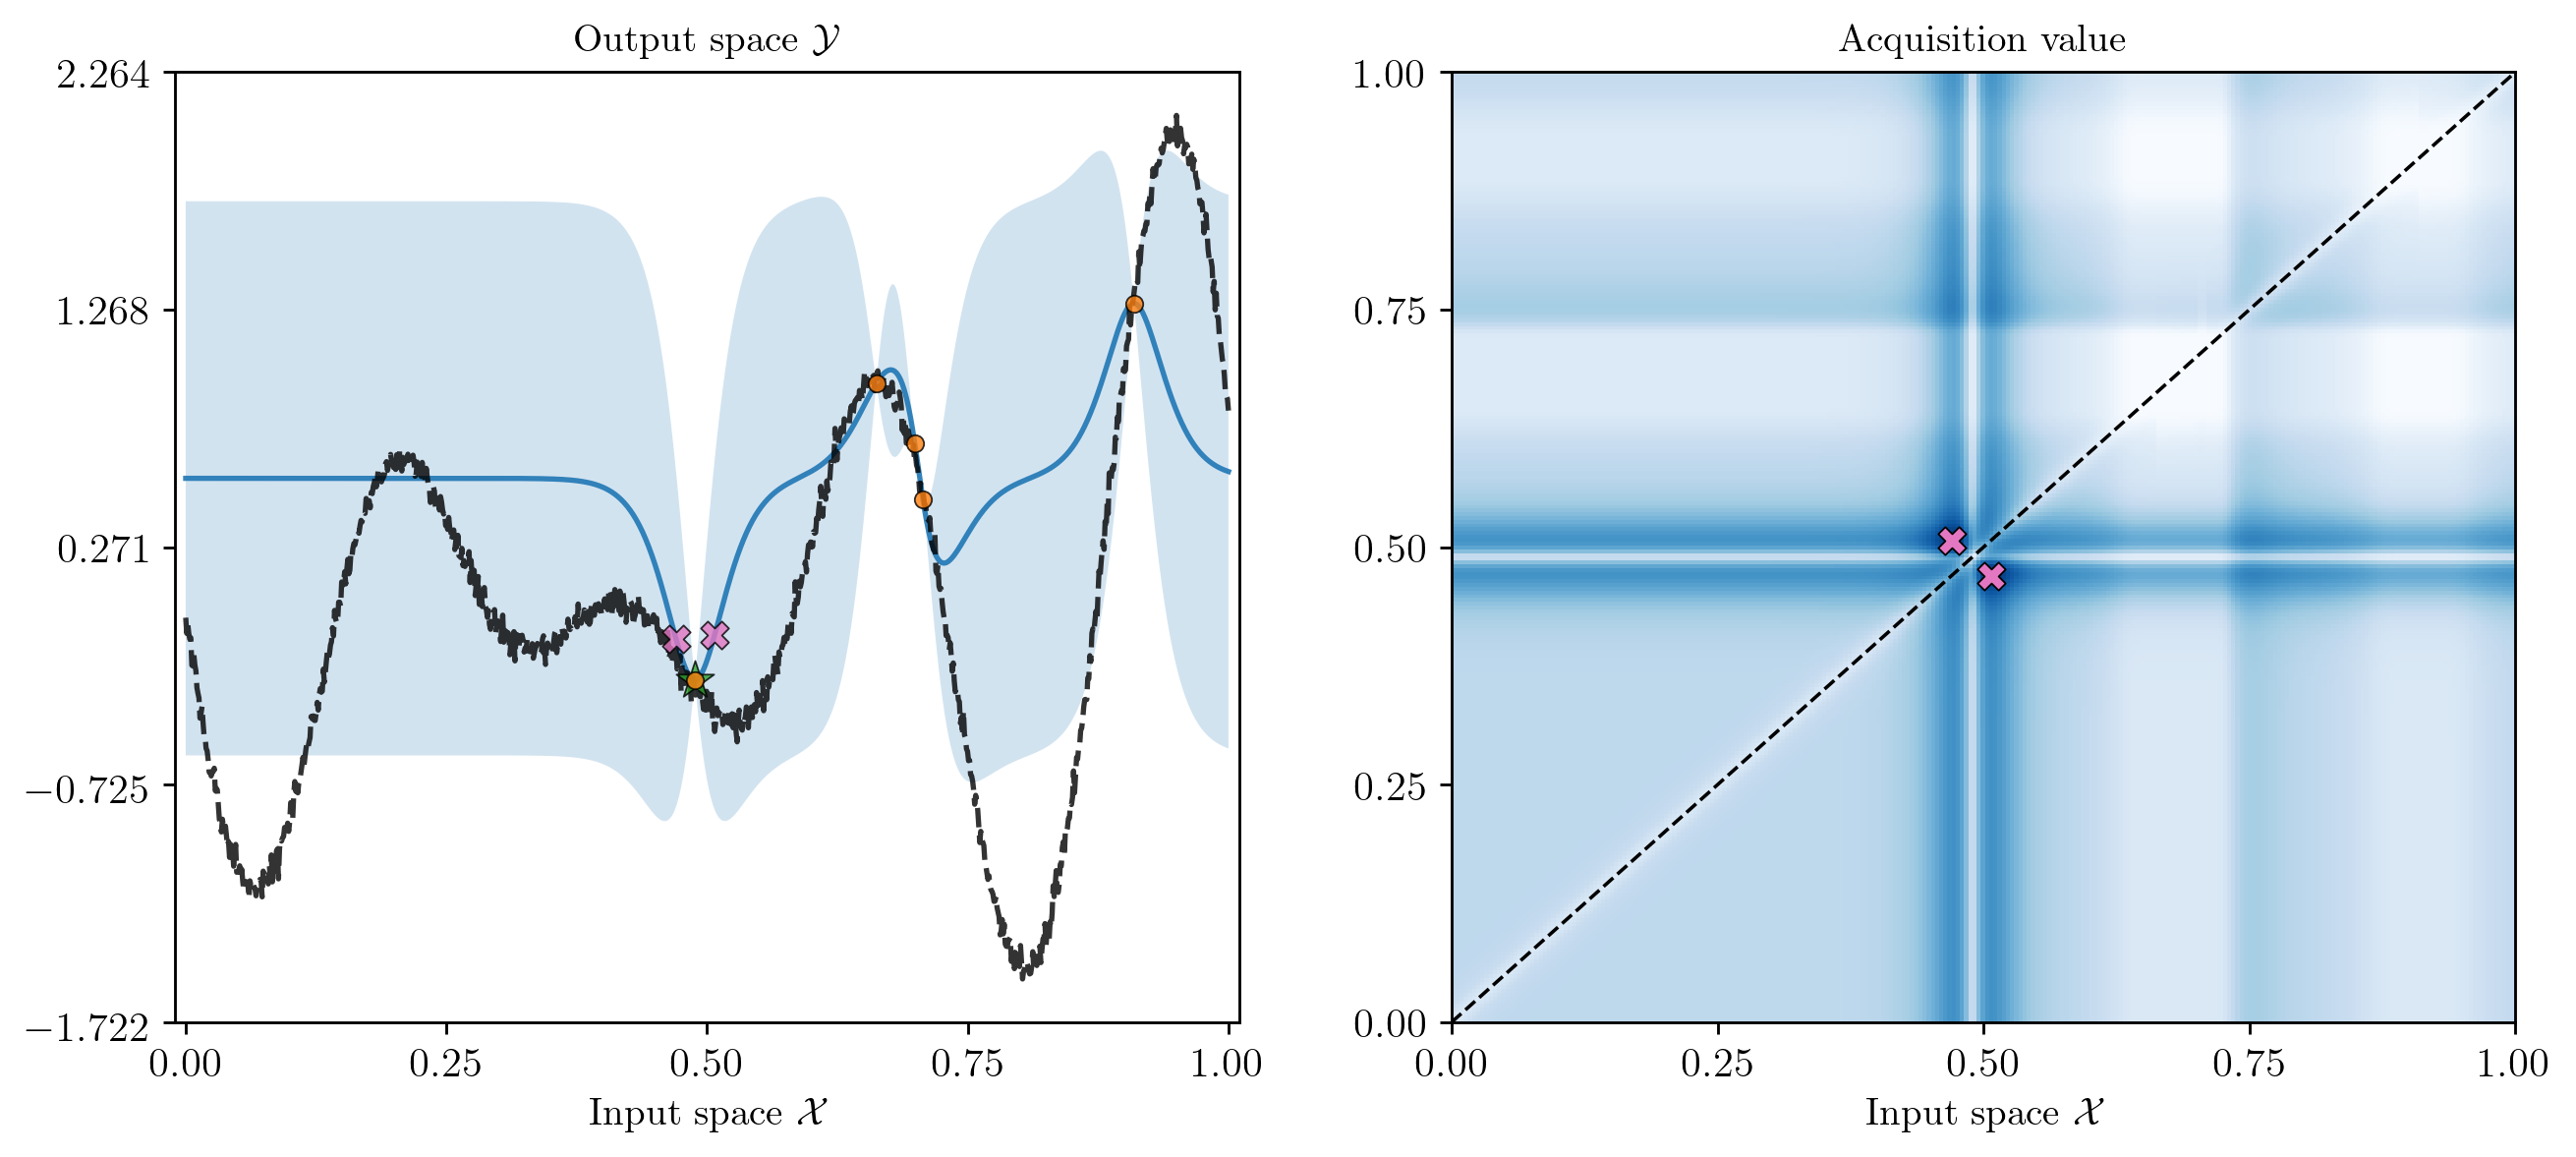

2018-11-27 14:17:42 INFO:run_bayesopt:2 job(s) finished
2018-11-27 14:17:42 INFO:run_bayesopt:Updating search agent
2018-11-27 14:17:42 INFO:src.agents.bayesian_optimization:Fit model in 5.74e-01s
2018-11-27 14:17:42 INFO:src.agents.bayesian_optimization:Updated model vars: [0.503, -2.704, -0.522, -5.601]
2018-11-27 14:17:42 INFO:src.agents.bayesian_optimization:Updated loss function in 5.81e-06s
2018-11-27 14:17:42 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:17:45 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 1108992 losses in 1.679e+00s
2018-11-27 14:17:45 INFO:run_bayesopt:Agent recommended f(x*=[[0.51]])=-4.349e-01
2018-11-27 14:17:45 INFO:run_bayesopt:Requesting 2 job suggestion(s)
2018-11-27 14:17:46 INFO:src.agents.bayesian_optimization:Evaluated 223488 marginal losses in 1.007e+00s
2018-11-27 14:17:55 INFO:src.agents.bayesian_optimization:SGD evaluated 2656 losses in 8.886e+00s


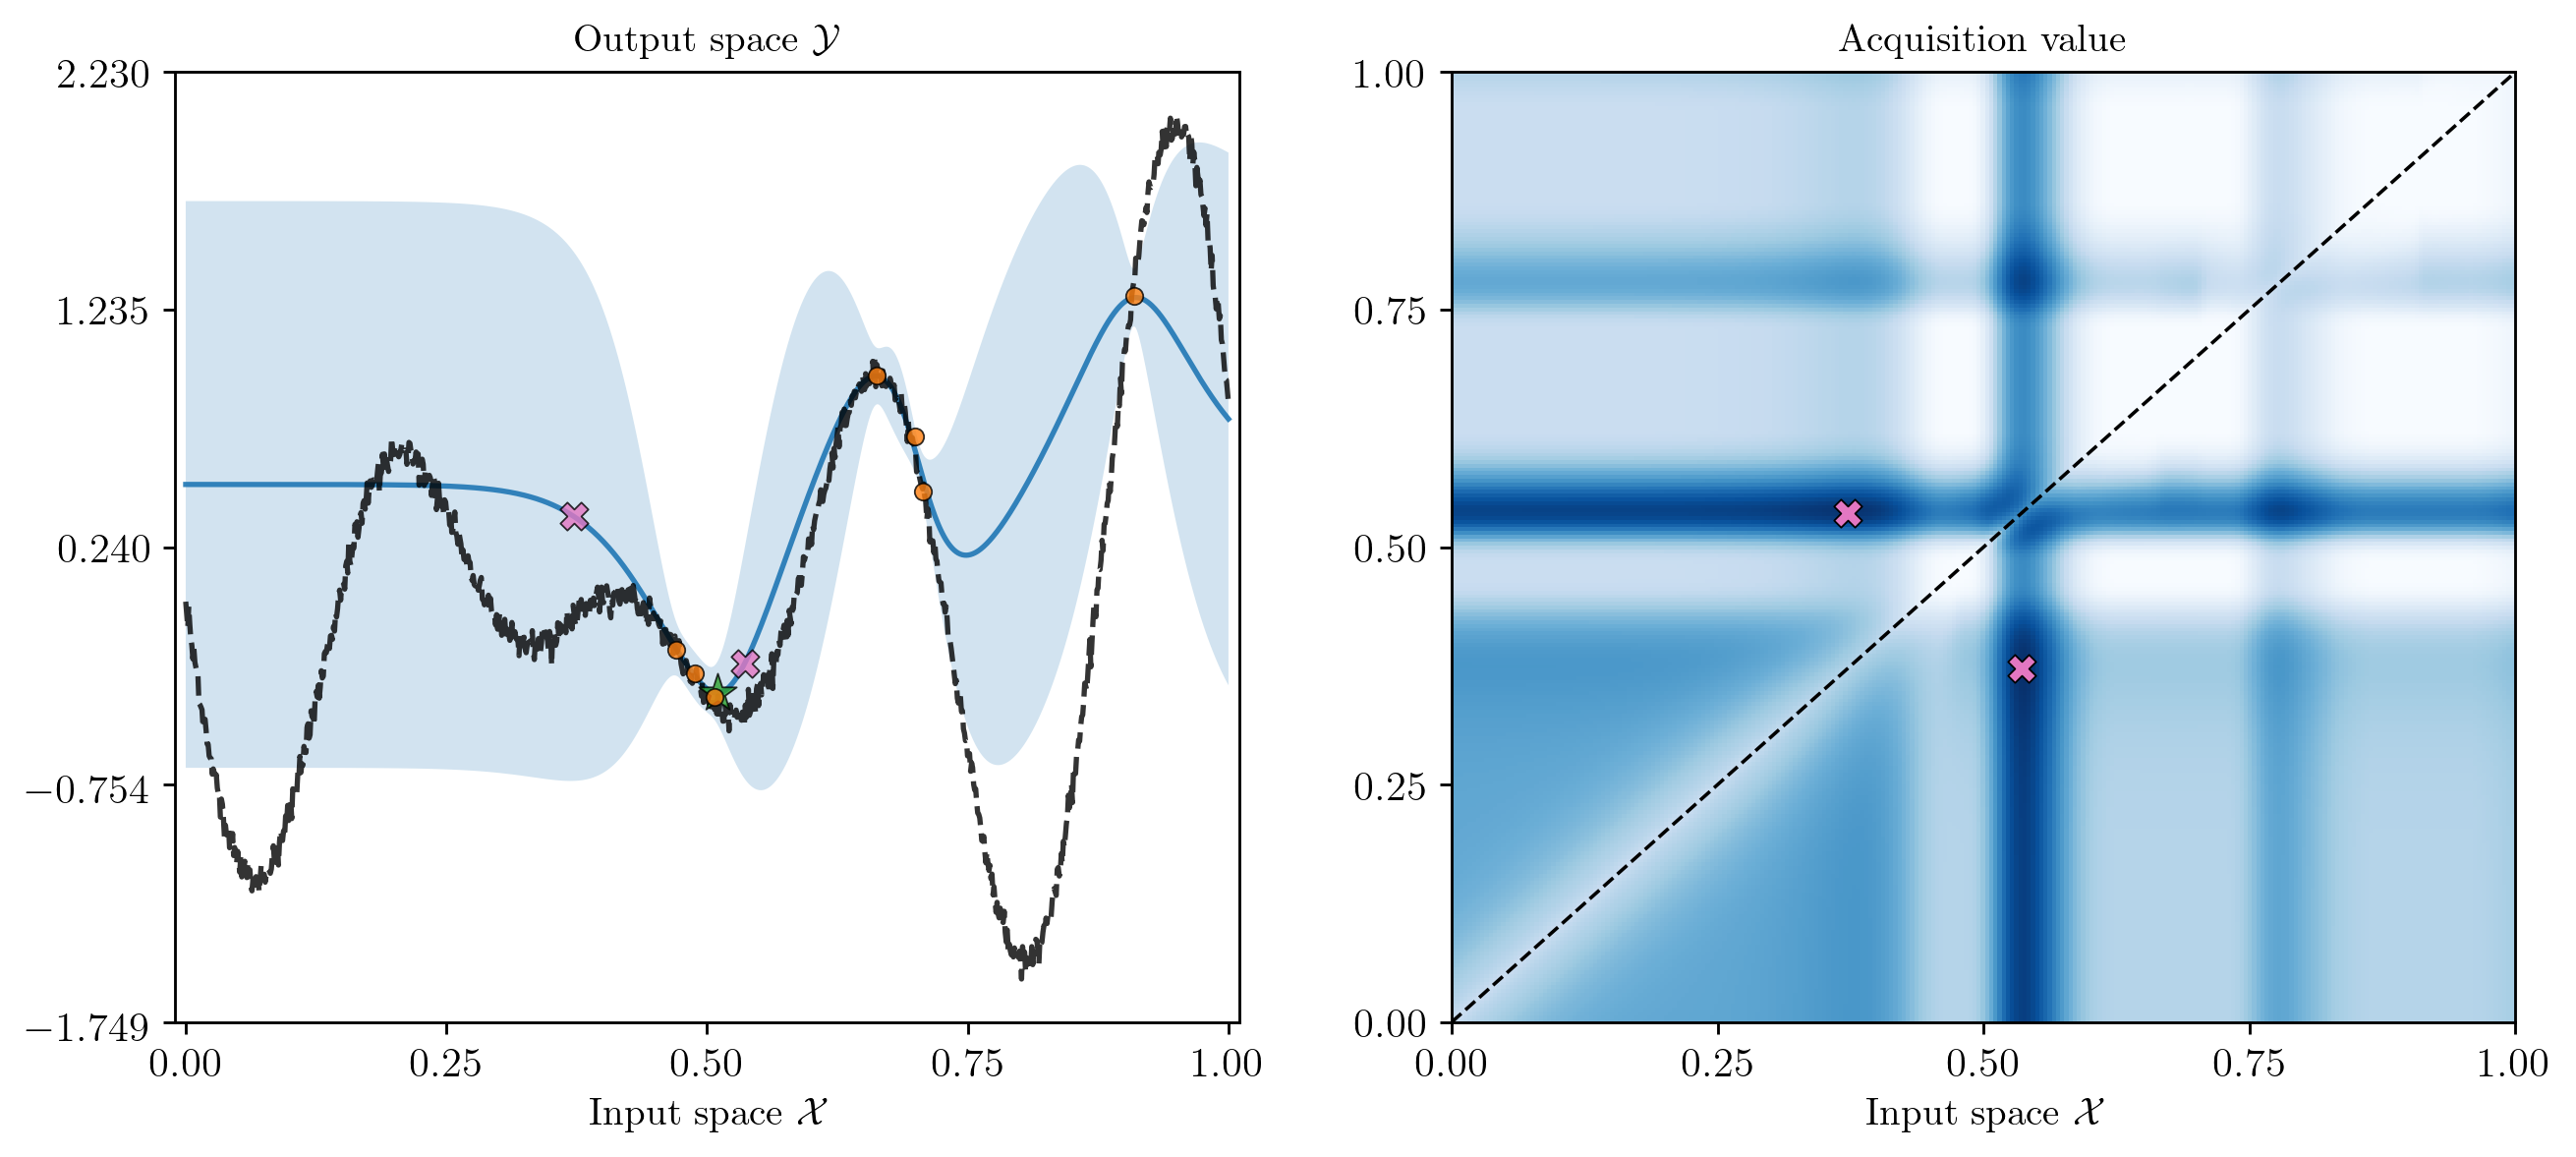

2018-11-27 14:17:58 INFO:run_bayesopt:2 job(s) finished
2018-11-27 14:17:58 INFO:run_bayesopt:Updating search agent
2018-11-27 14:17:59 INFO:src.agents.bayesian_optimization:Fit model in 6.74e-01s
2018-11-27 14:17:59 INFO:src.agents.bayesian_optimization:Updated model vars: [0.395, -2.617, -0.525, -5.856]
2018-11-27 14:17:59 INFO:src.agents.bayesian_optimization:Updated loss function in 7.33e-06s
2018-11-27 14:17:59 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:18:00 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 446464 losses in 7.940e-01s
2018-11-27 14:18:00 INFO:run_bayesopt:Agent recommended f(x*=[[0.527]])=-4.600e-01
2018-11-27 14:18:00 INFO:run_bayesopt:Requesting 2 job suggestion(s)
2018-11-27 14:18:01 INFO:src.agents.bayesian_optimization:Evaluated 216064 marginal losses in 1.004e+00s
2018-11-27 14:18:10 INFO:src.agents.bayesian_optimization:SGD evaluated 2432 losses in 8.840e+00s


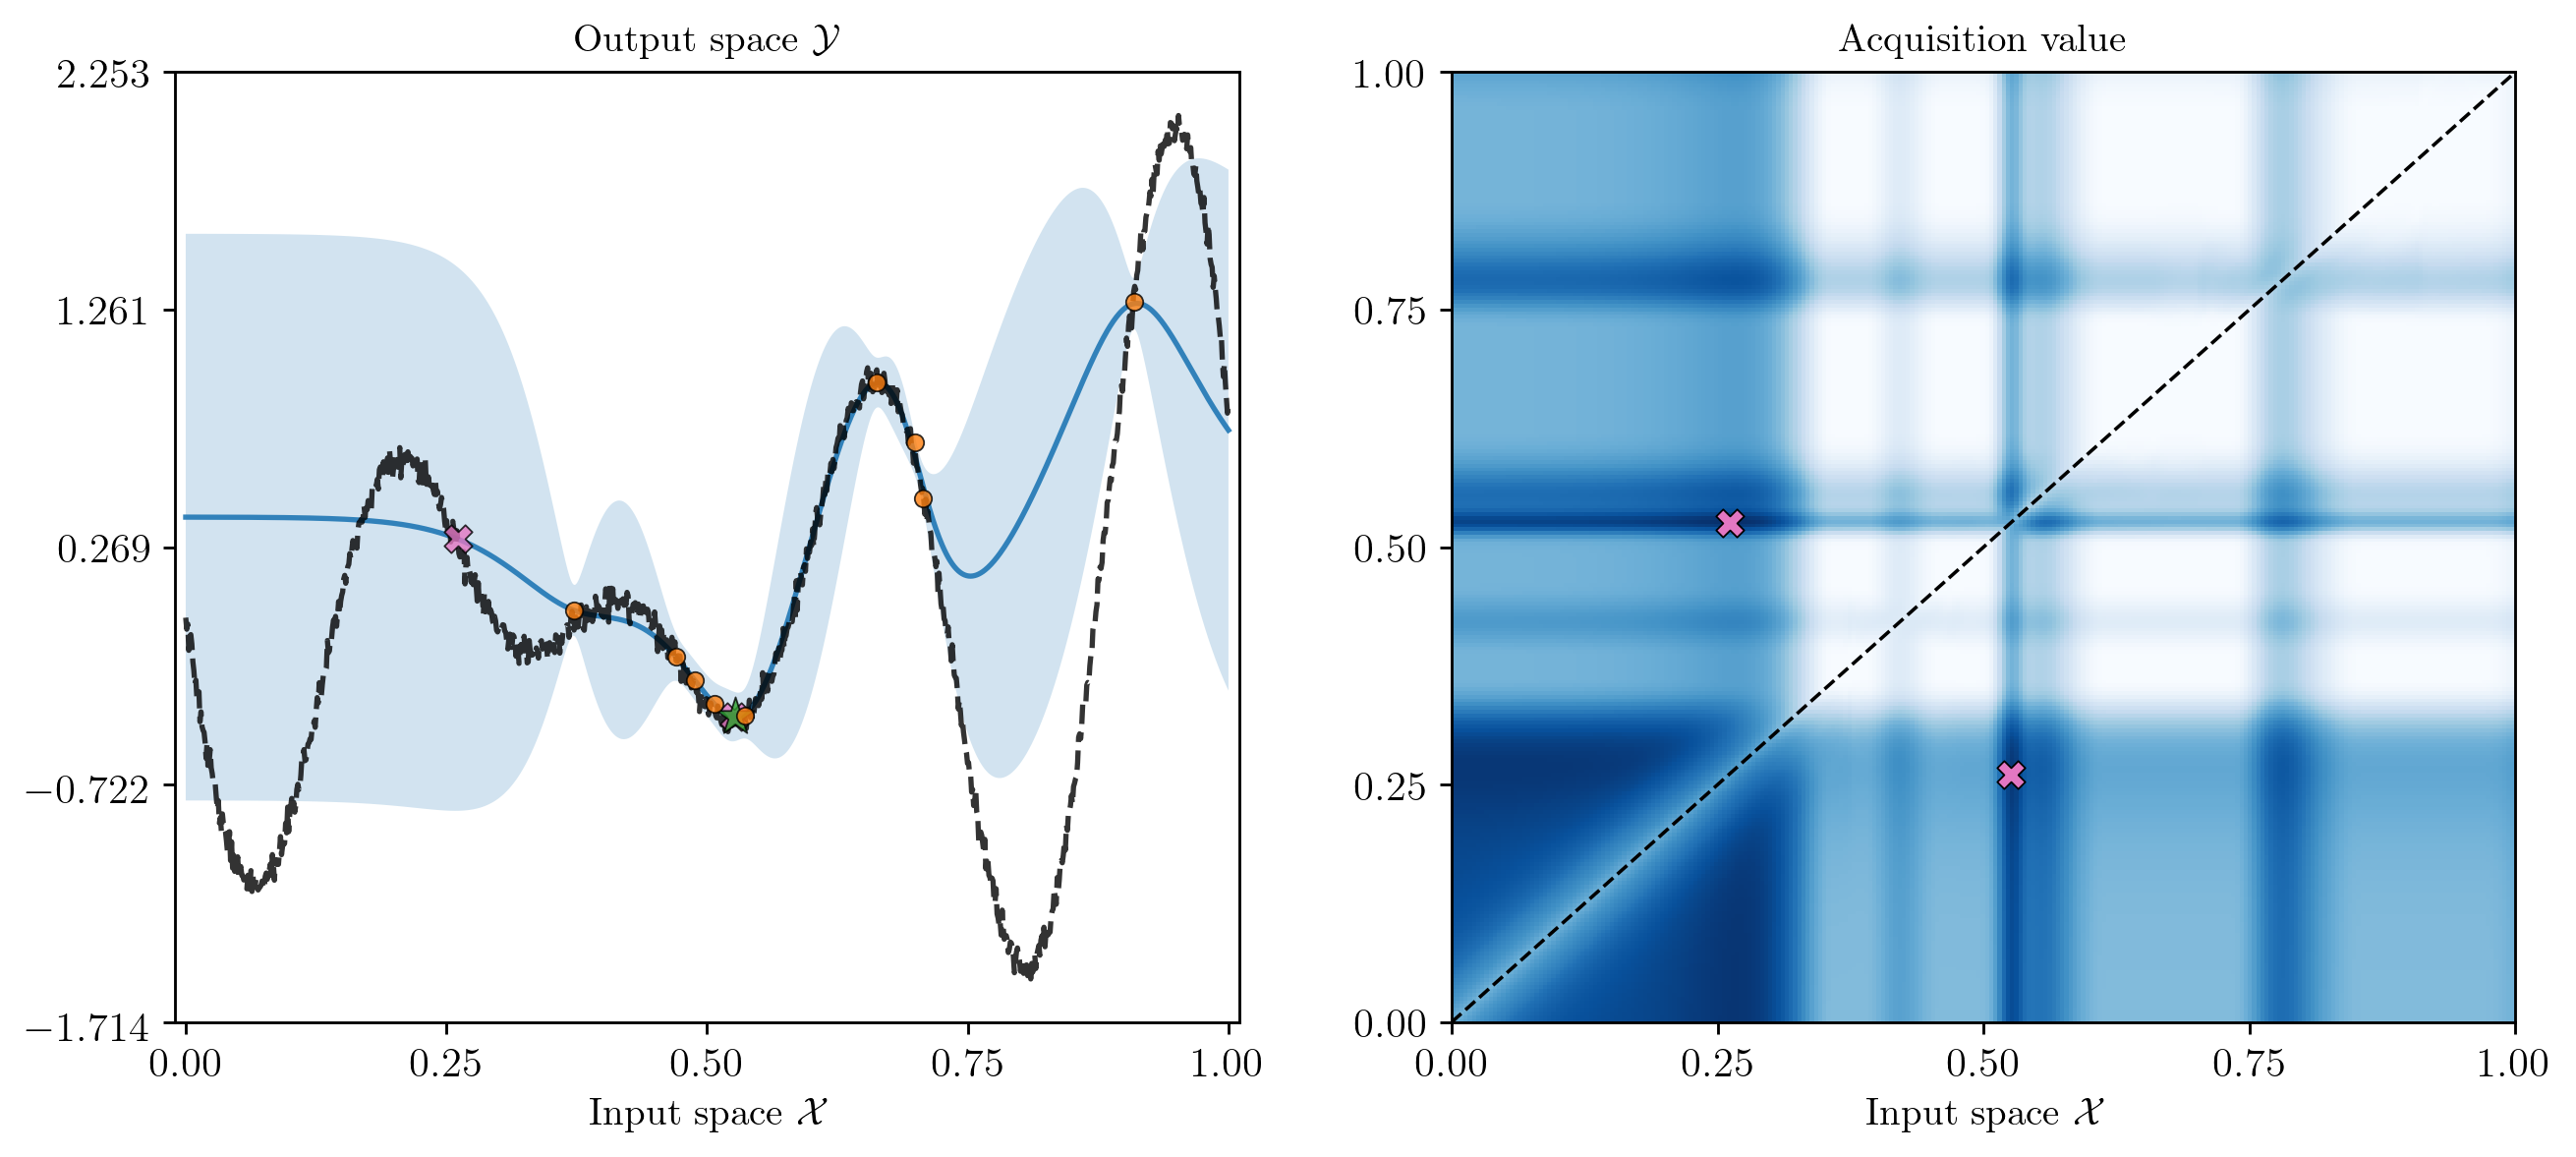

2018-11-27 14:18:15 INFO:run_bayesopt:2 job(s) finished
2018-11-27 14:18:15 INFO:run_bayesopt:Updating search agent
2018-11-27 14:18:15 INFO:src.agents.bayesian_optimization:Fit model in 8.81e-01s
2018-11-27 14:18:15 INFO:src.agents.bayesian_optimization:Updated model vars: [0.393, -2.669, -0.596, -5.966]
2018-11-27 14:18:15 INFO:src.agents.bayesian_optimization:Updated loss function in 9.45e-06s
2018-11-27 14:18:15 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:18:17 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 849920 losses in 1.463e+00s
2018-11-27 14:18:17 INFO:run_bayesopt:Agent recommended f(x*=[[0.526]])=-4.609e-01
2018-11-27 14:18:17 INFO:run_bayesopt:Requesting 2 job suggestion(s)
2018-11-27 14:18:18 INFO:src.agents.bayesian_optimization:Evaluated 201984 marginal losses in 1.008e+00s
2018-11-27 14:18:27 INFO:src.agents.bayesian_optimization:SGD evaluated 2176 losses in 8.803e+00s


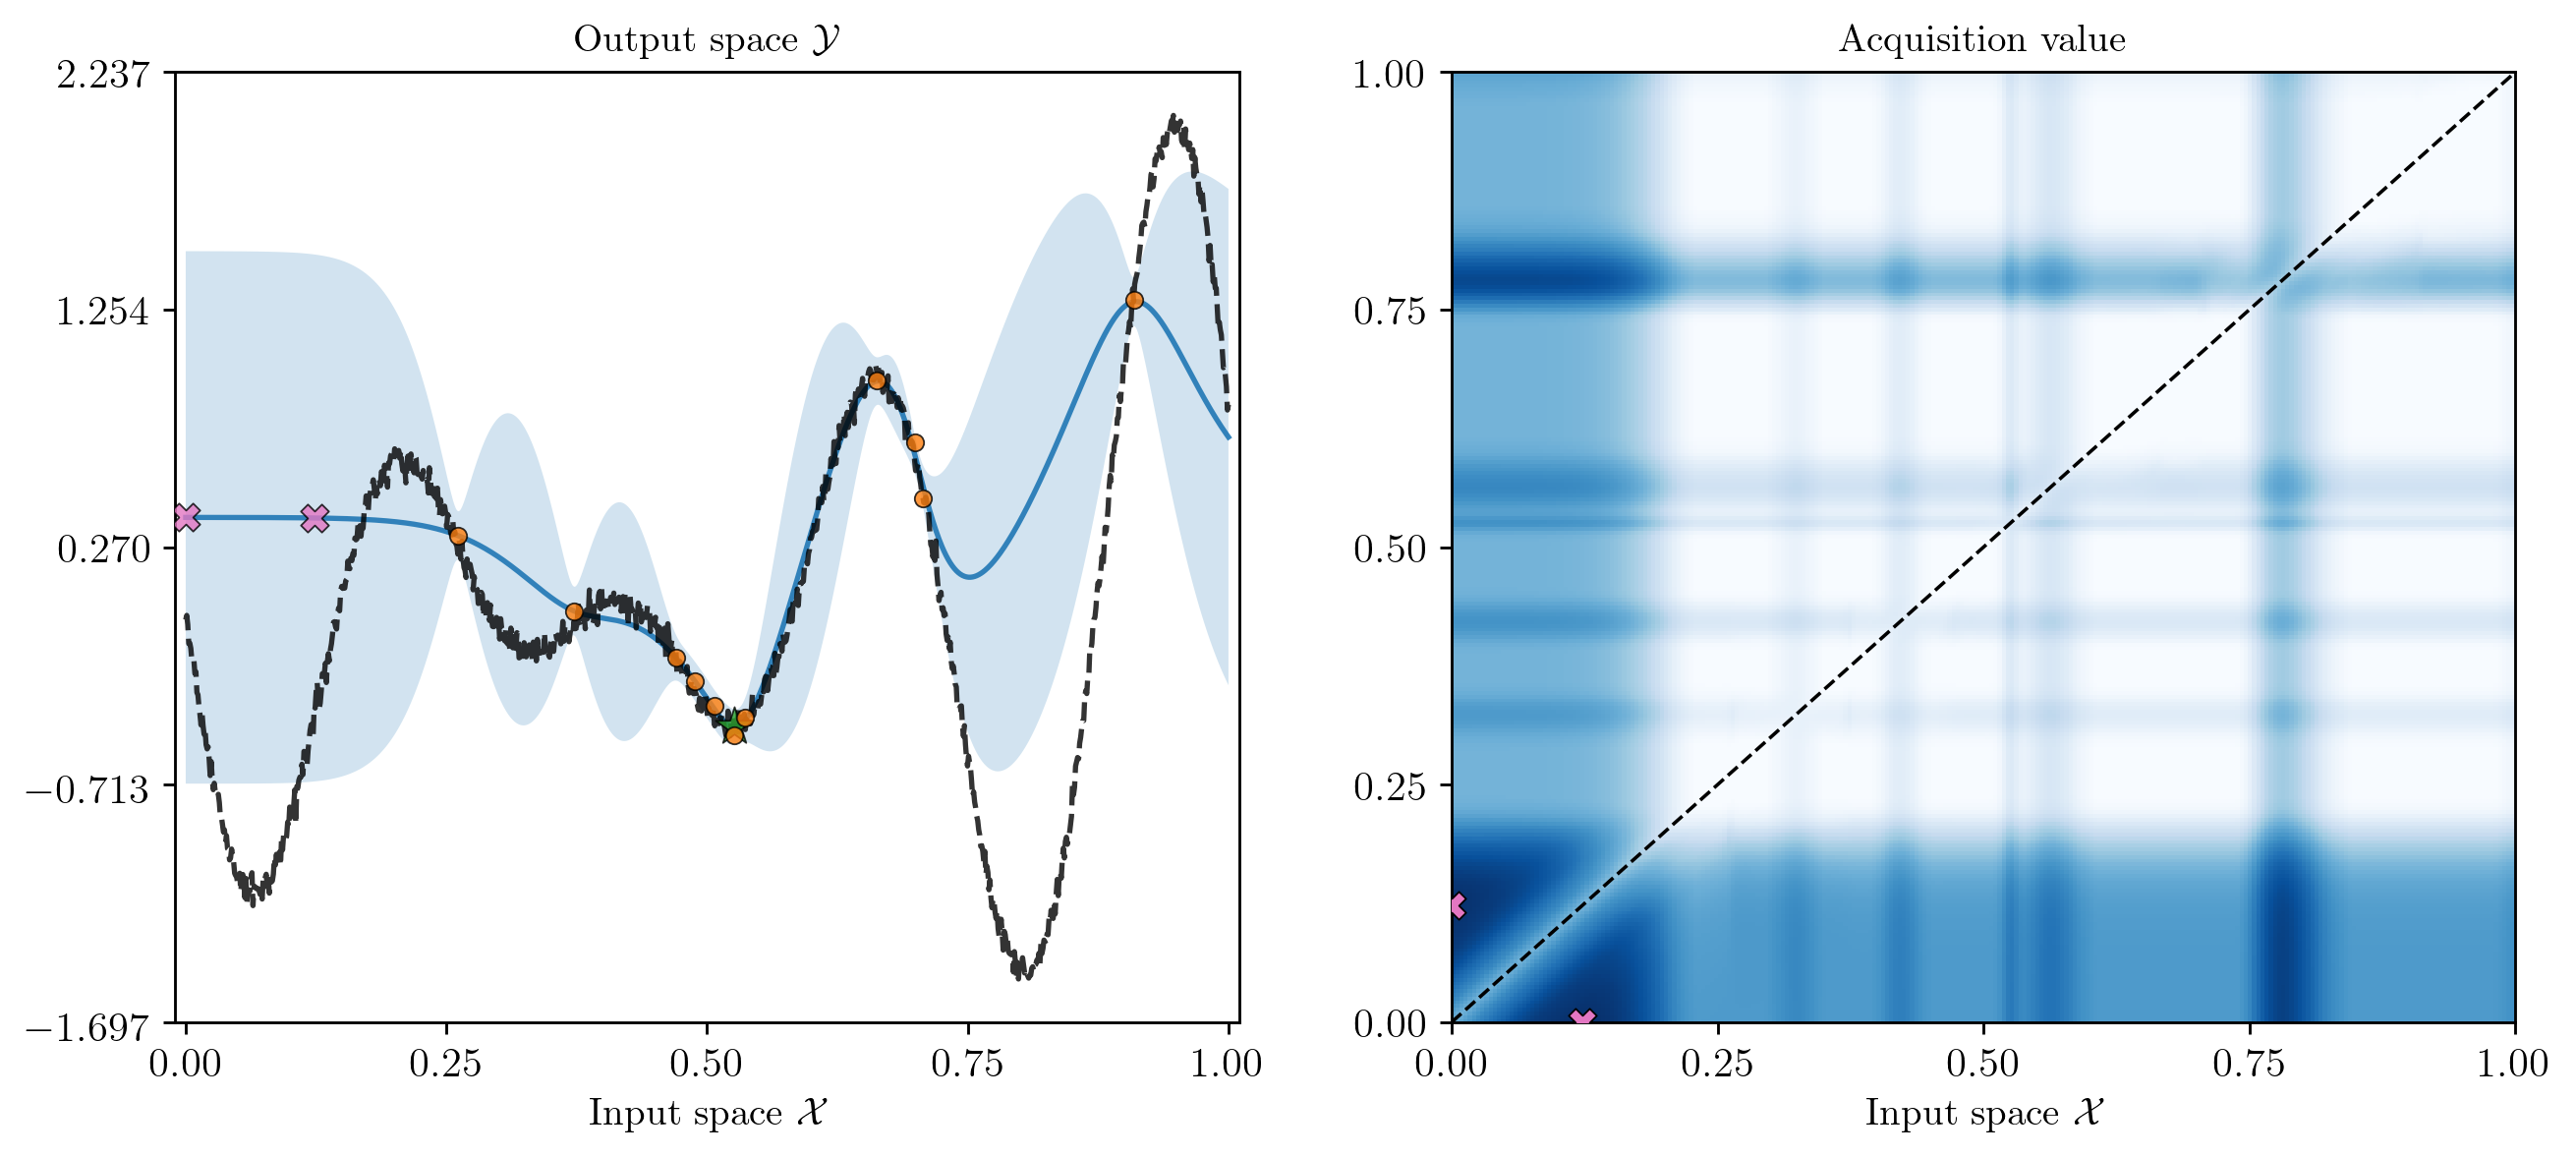

2018-11-27 14:18:31 INFO:run_bayesopt:1 job(s) finished
2018-11-27 14:18:31 INFO:run_bayesopt:Updating search agent
2018-11-27 14:18:32 INFO:src.agents.bayesian_optimization:Fit model in 6.96e-01s
2018-11-27 14:18:32 INFO:src.agents.bayesian_optimization:Updated model vars: [0.257, -2.701, -0.562, -6.106]
2018-11-27 14:18:32 INFO:src.agents.bayesian_optimization:Updated loss function in 6.04e-06s
2018-11-27 14:18:32 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:18:32 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 52224 losses in 9.187e-02s
2018-11-27 14:18:32 INFO:run_bayesopt:Agent recommended f(x*=[[0.526]])=-4.609e-01
2018-11-27 14:18:32 INFO:run_bayesopt:Requesting 1 job suggestion(s)
2018-11-27 14:18:33 INFO:src.agents.bayesian_optimization:Evaluated 211712 marginal losses in 1.006e+00s
2018-11-27 14:18:43 INFO:src.agents.bayesian_optimization:SGD evaluated 1664 losses in 8.475e+00s


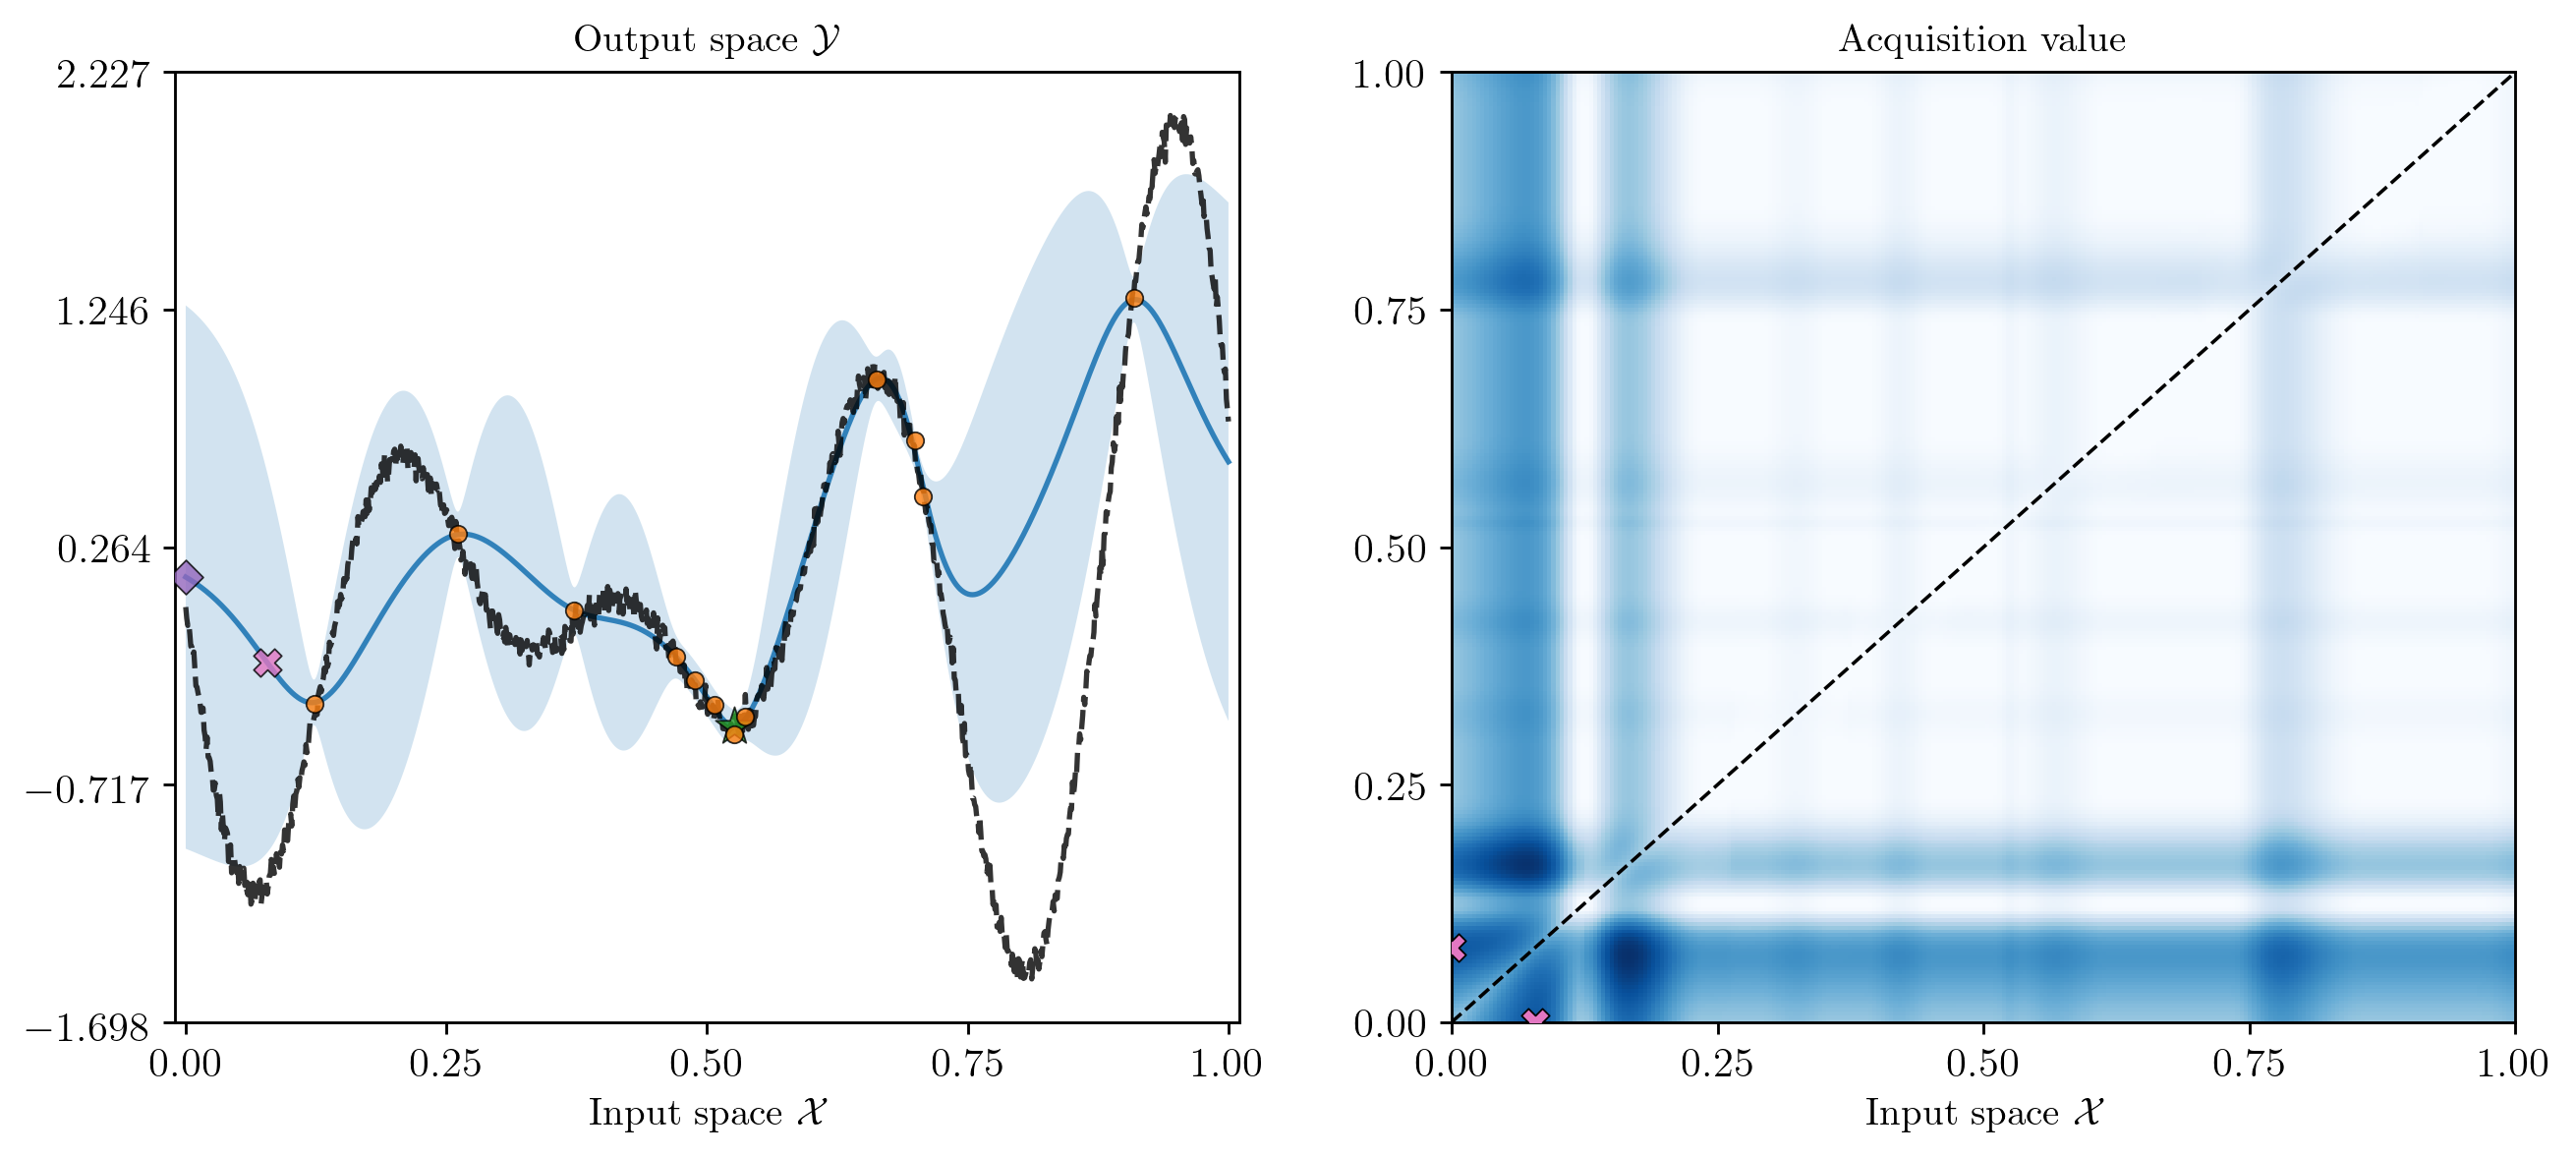

2018-11-27 14:18:48 INFO:run_bayesopt:1 job(s) finished
2018-11-27 14:18:48 INFO:run_bayesopt:Updating search agent
2018-11-27 14:18:49 INFO:src.agents.bayesian_optimization:Fit model in 9.99e-01s
2018-11-27 14:18:49 INFO:src.agents.bayesian_optimization:Updated model vars: [0.139, -2.714, -0.394, -6.485]
2018-11-27 14:18:49 INFO:src.agents.bayesian_optimization:Updated loss function in 9.17e-06s
2018-11-27 14:18:49 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:18:50 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 47104 losses in 9.358e-02s
2018-11-27 14:18:50 INFO:run_bayesopt:Agent recommended f(x*=[[0.067]])=-1.150e+00
2018-11-27 14:18:50 INFO:run_bayesopt:Requesting 1 job suggestion(s)
2018-11-27 14:18:51 INFO:src.agents.bayesian_optimization:Evaluated 222208 marginal losses in 1.004e+00s
2018-11-27 14:19:00 INFO:src.agents.bayesian_optimization:SGD evaluated 1504 losses in 8.897e+00s


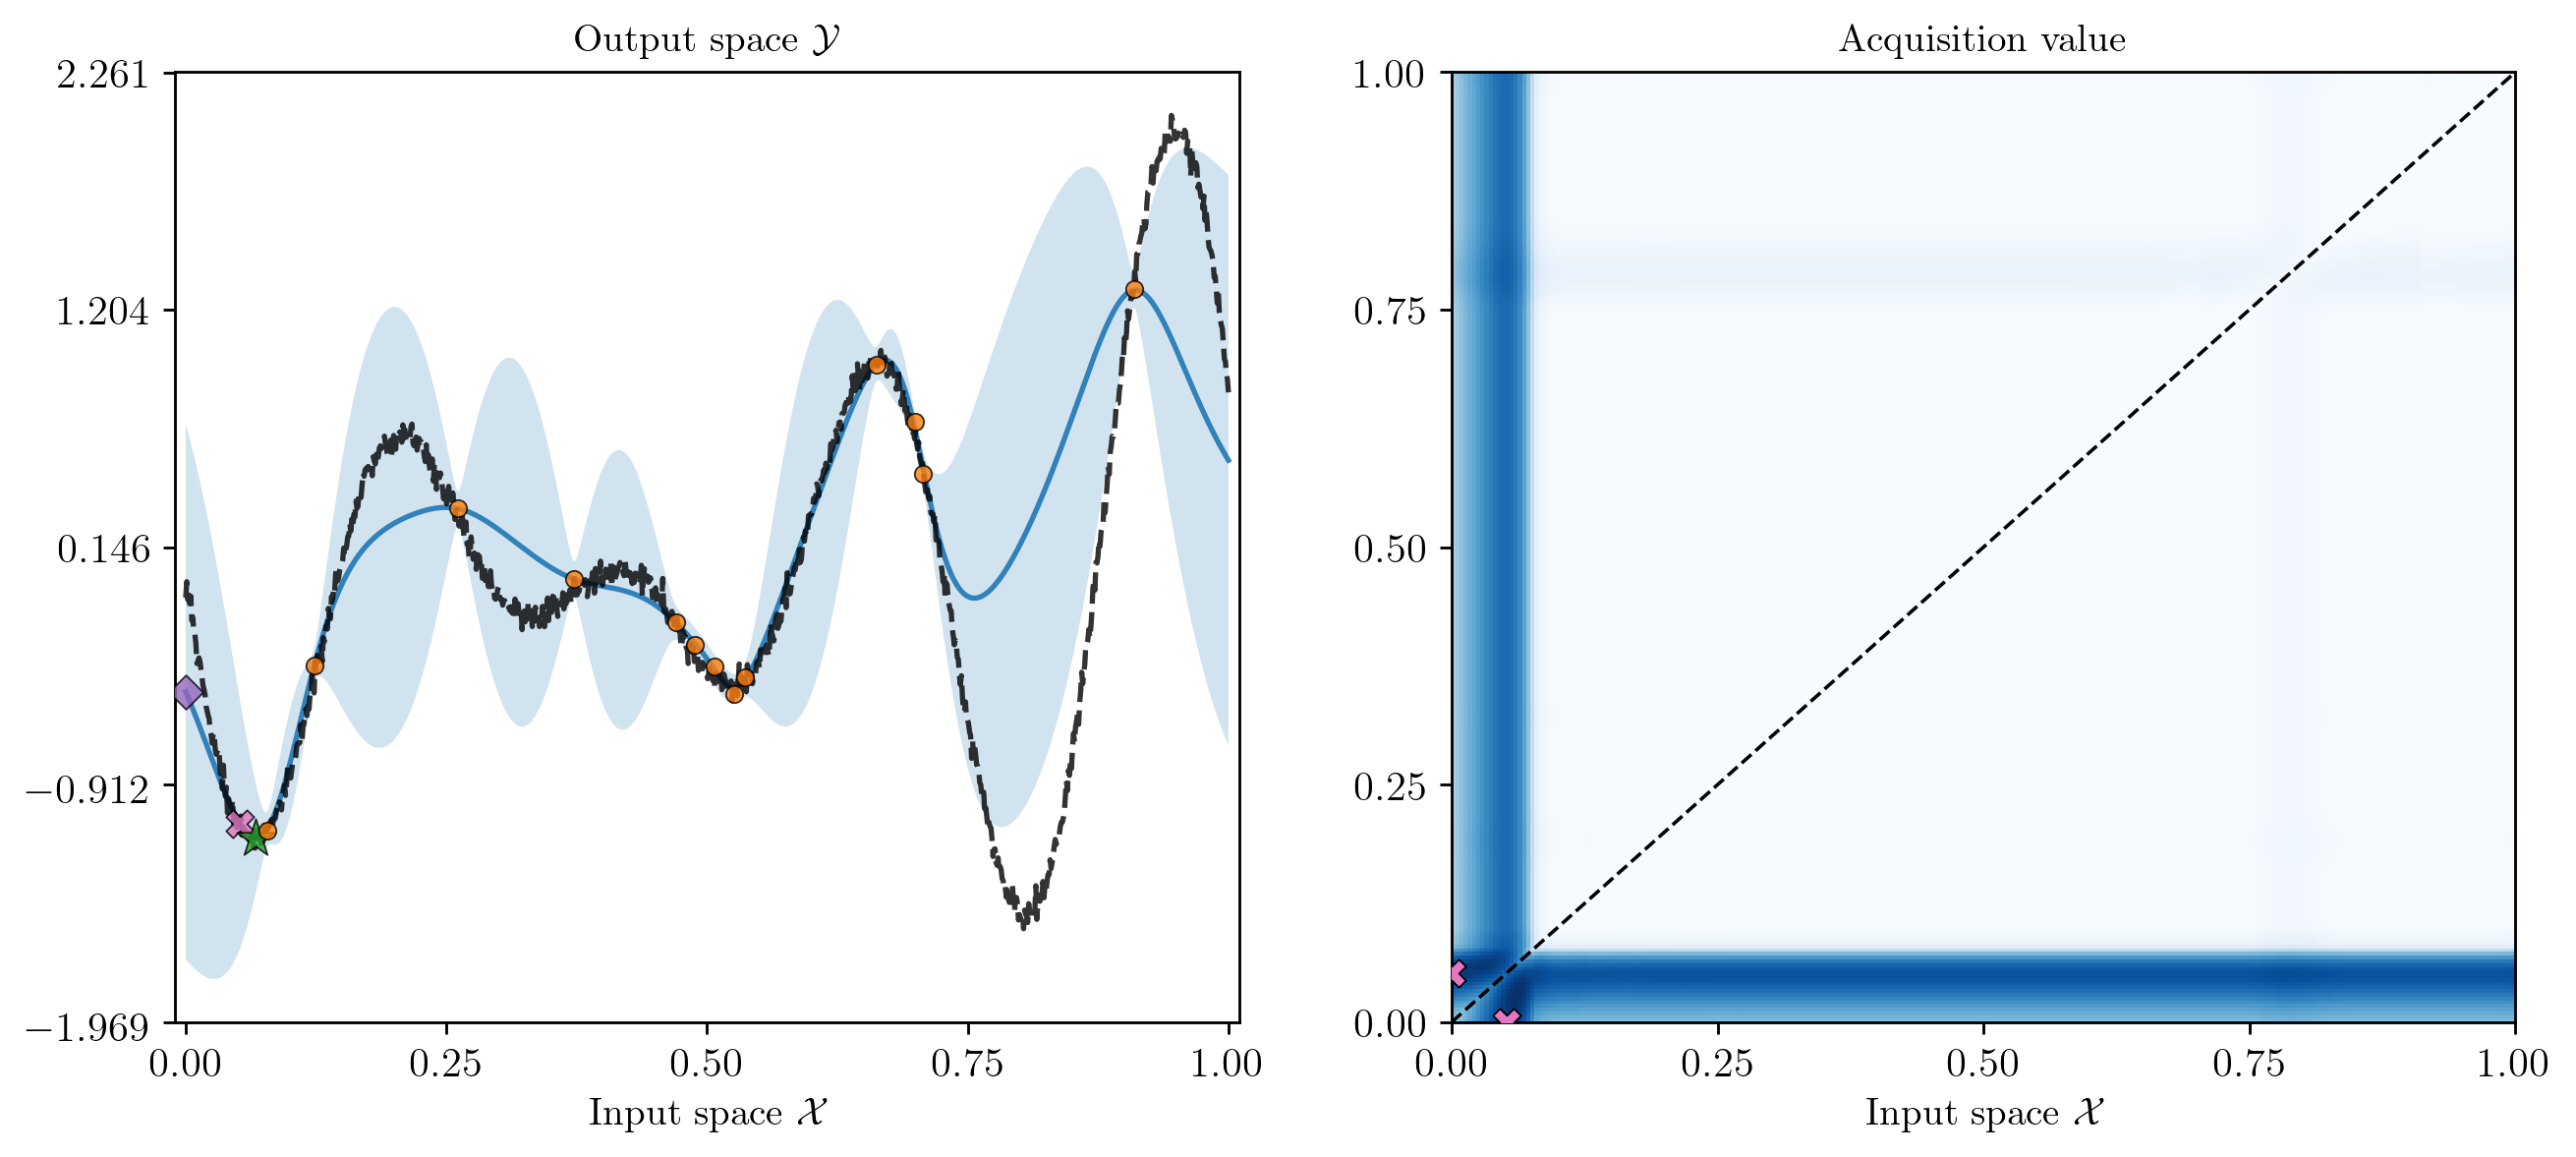

2018-11-27 14:19:04 INFO:run_bayesopt:1 job(s) finished
2018-11-27 14:19:04 INFO:run_bayesopt:Updating search agent
2018-11-27 14:19:04 INFO:src.agents.bayesian_optimization:Fit model in 9.81e-01s
2018-11-27 14:19:05 INFO:src.agents.bayesian_optimization:Updated model vars: [0.16, -2.665, -0.422, -6.261]
2018-11-27 14:19:05 INFO:src.agents.bayesian_optimization:Updated loss function in 6.85e-06s
2018-11-27 14:19:05 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:19:05 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 53248 losses in 9.644e-02s
2018-11-27 14:19:05 INFO:run_bayesopt:Agent recommended f(x*=[[0.071]])=-1.145e+00
2018-11-27 14:19:05 INFO:run_bayesopt:Requesting 1 job suggestion(s)
2018-11-27 14:19:06 INFO:src.agents.bayesian_optimization:Evaluated 191488 marginal losses in 1.004e+00s
2018-11-27 14:19:15 INFO:src.agents.bayesian_optimization:SGD evaluated 1408 losses in 8.894e+00s


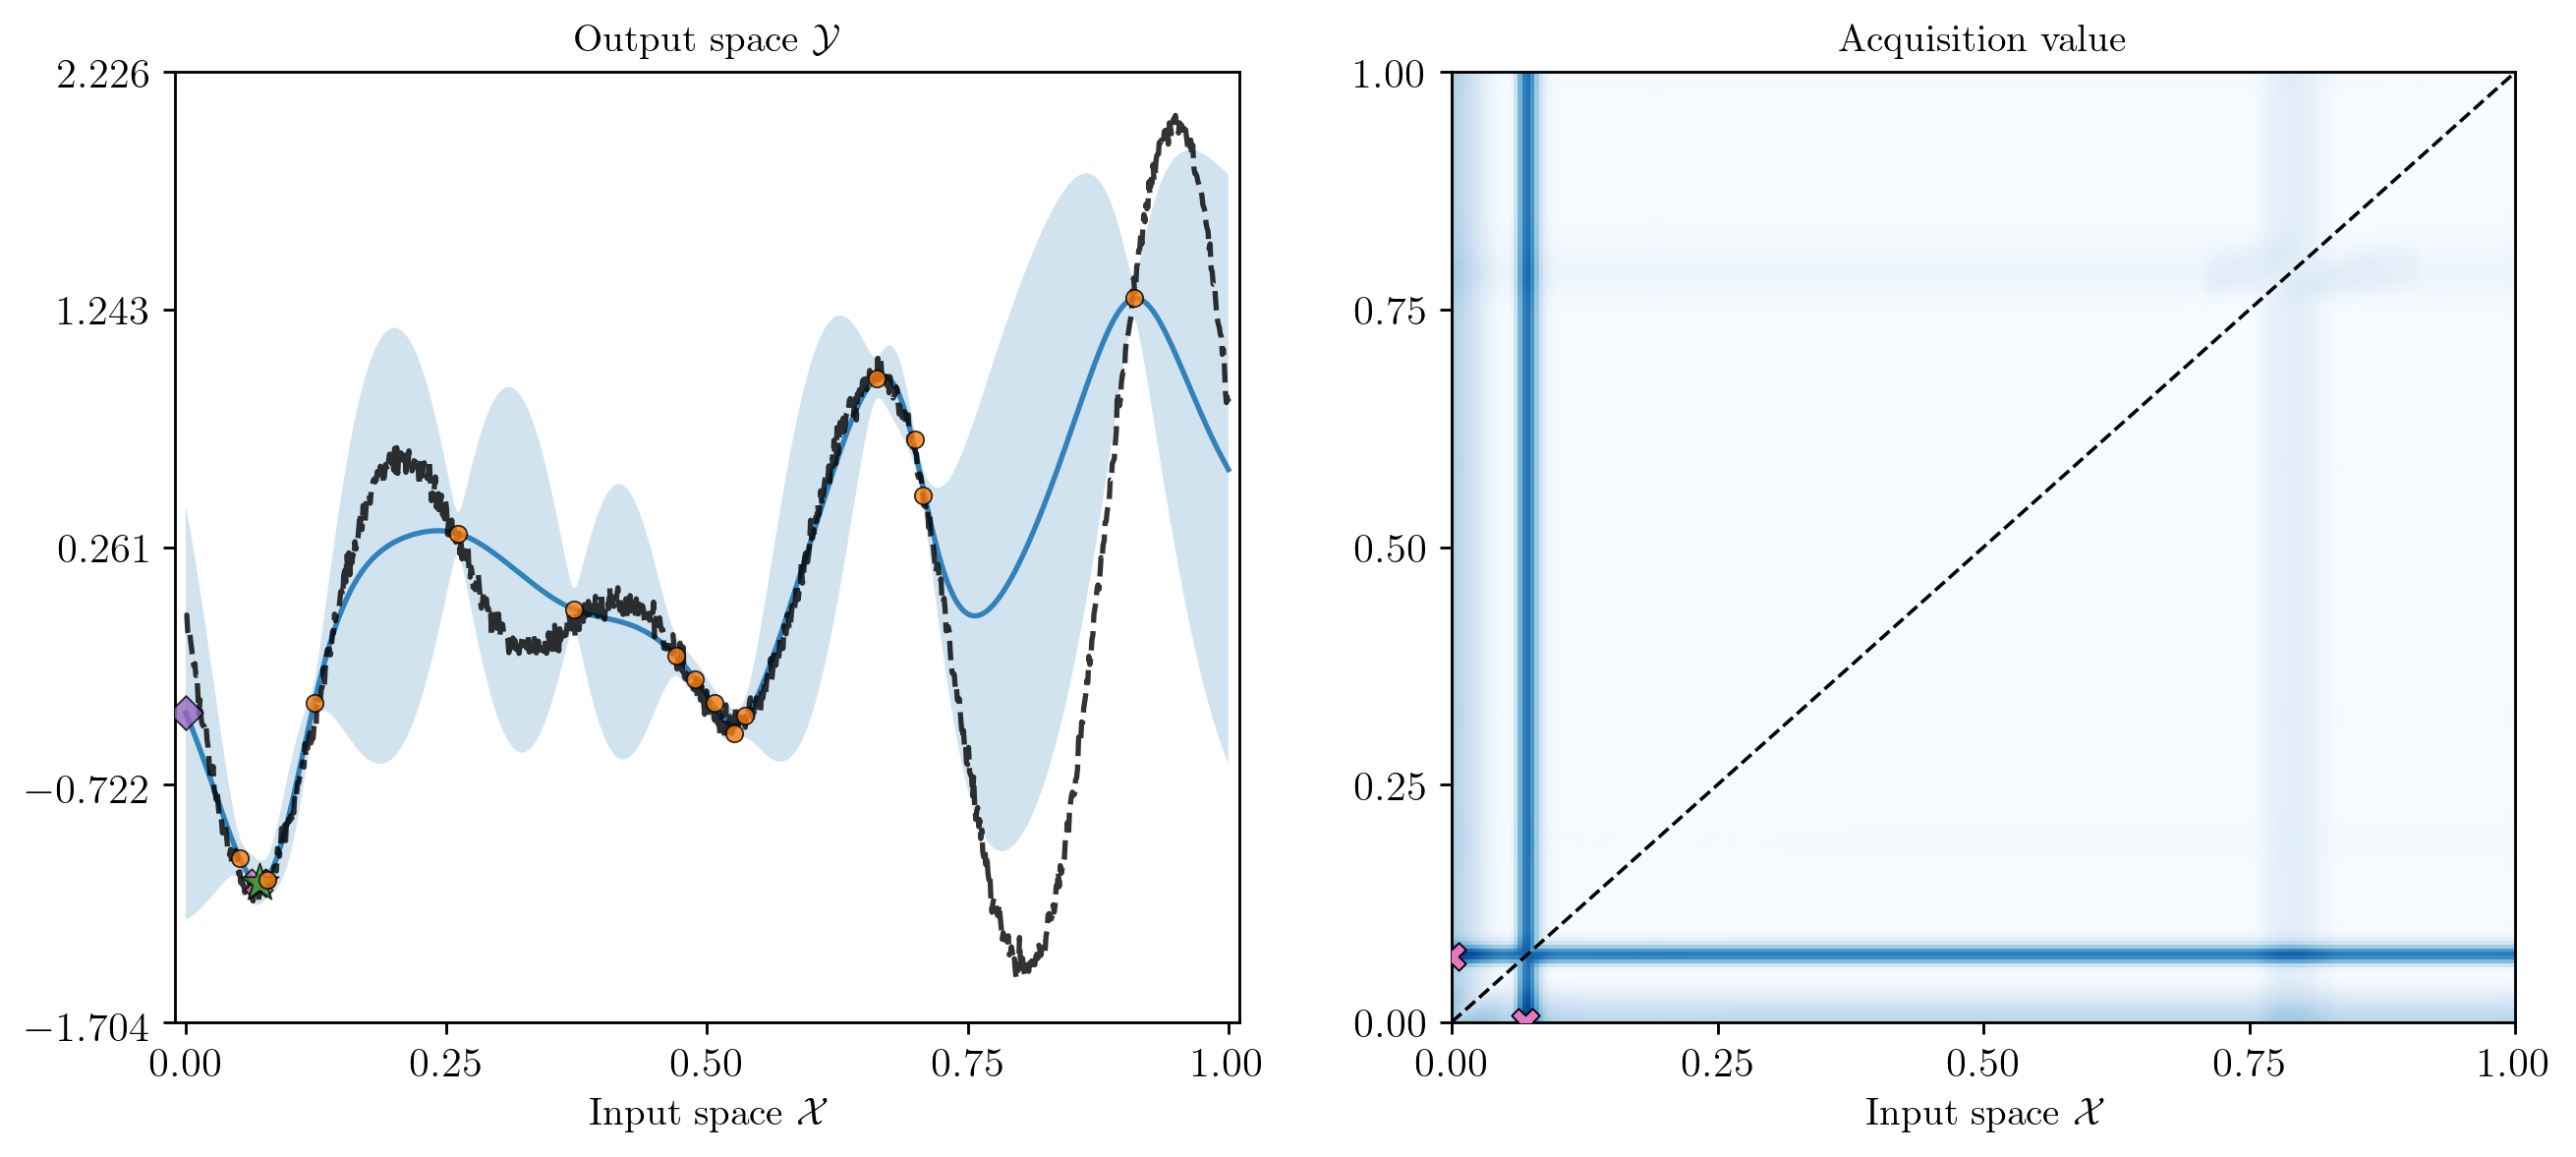

2018-11-27 14:19:20 INFO:run_bayesopt:1 job(s) finished
2018-11-27 14:19:20 INFO:run_bayesopt:Updating search agent
2018-11-27 14:19:21 INFO:src.agents.bayesian_optimization:Fit model in 1.03e+00s
2018-11-27 14:19:21 INFO:src.agents.bayesian_optimization:Updated model vars: [0.14, -2.942, -0.452, -352.977]
2018-11-27 14:19:21 INFO:src.agents.bayesian_optimization:Updated loss function in 1.23e-05s
2018-11-27 14:19:21 INFO:run_bayesopt:Requesting updated answer
2018-11-27 14:19:21 INFO:src.agents.bayesian_optimization:ScipyOptimize evaluated 66560 losses in 1.713e-01s
2018-11-27 14:19:21 INFO:run_bayesopt:Agent recommended f(x*=[[0.068]])=-1.149e+00
2018-11-27 14:19:21 INFO:run_bayesopt:1 job(s) finished
2018-11-27 14:19:21 INFO:run_bayesopt:Updating search agent
2018-11-27 14:19:22 INFO:src.agents.bayesian_optimization:Fit model in 1.07e+00s
2018-11-27 14:19:22 INFO:src.agents.bayesian_optimization:Updated model vars: [0.161, -2.938, -0.475, -352.676]
2018-11-27 14:19:22 INFO:src.agent

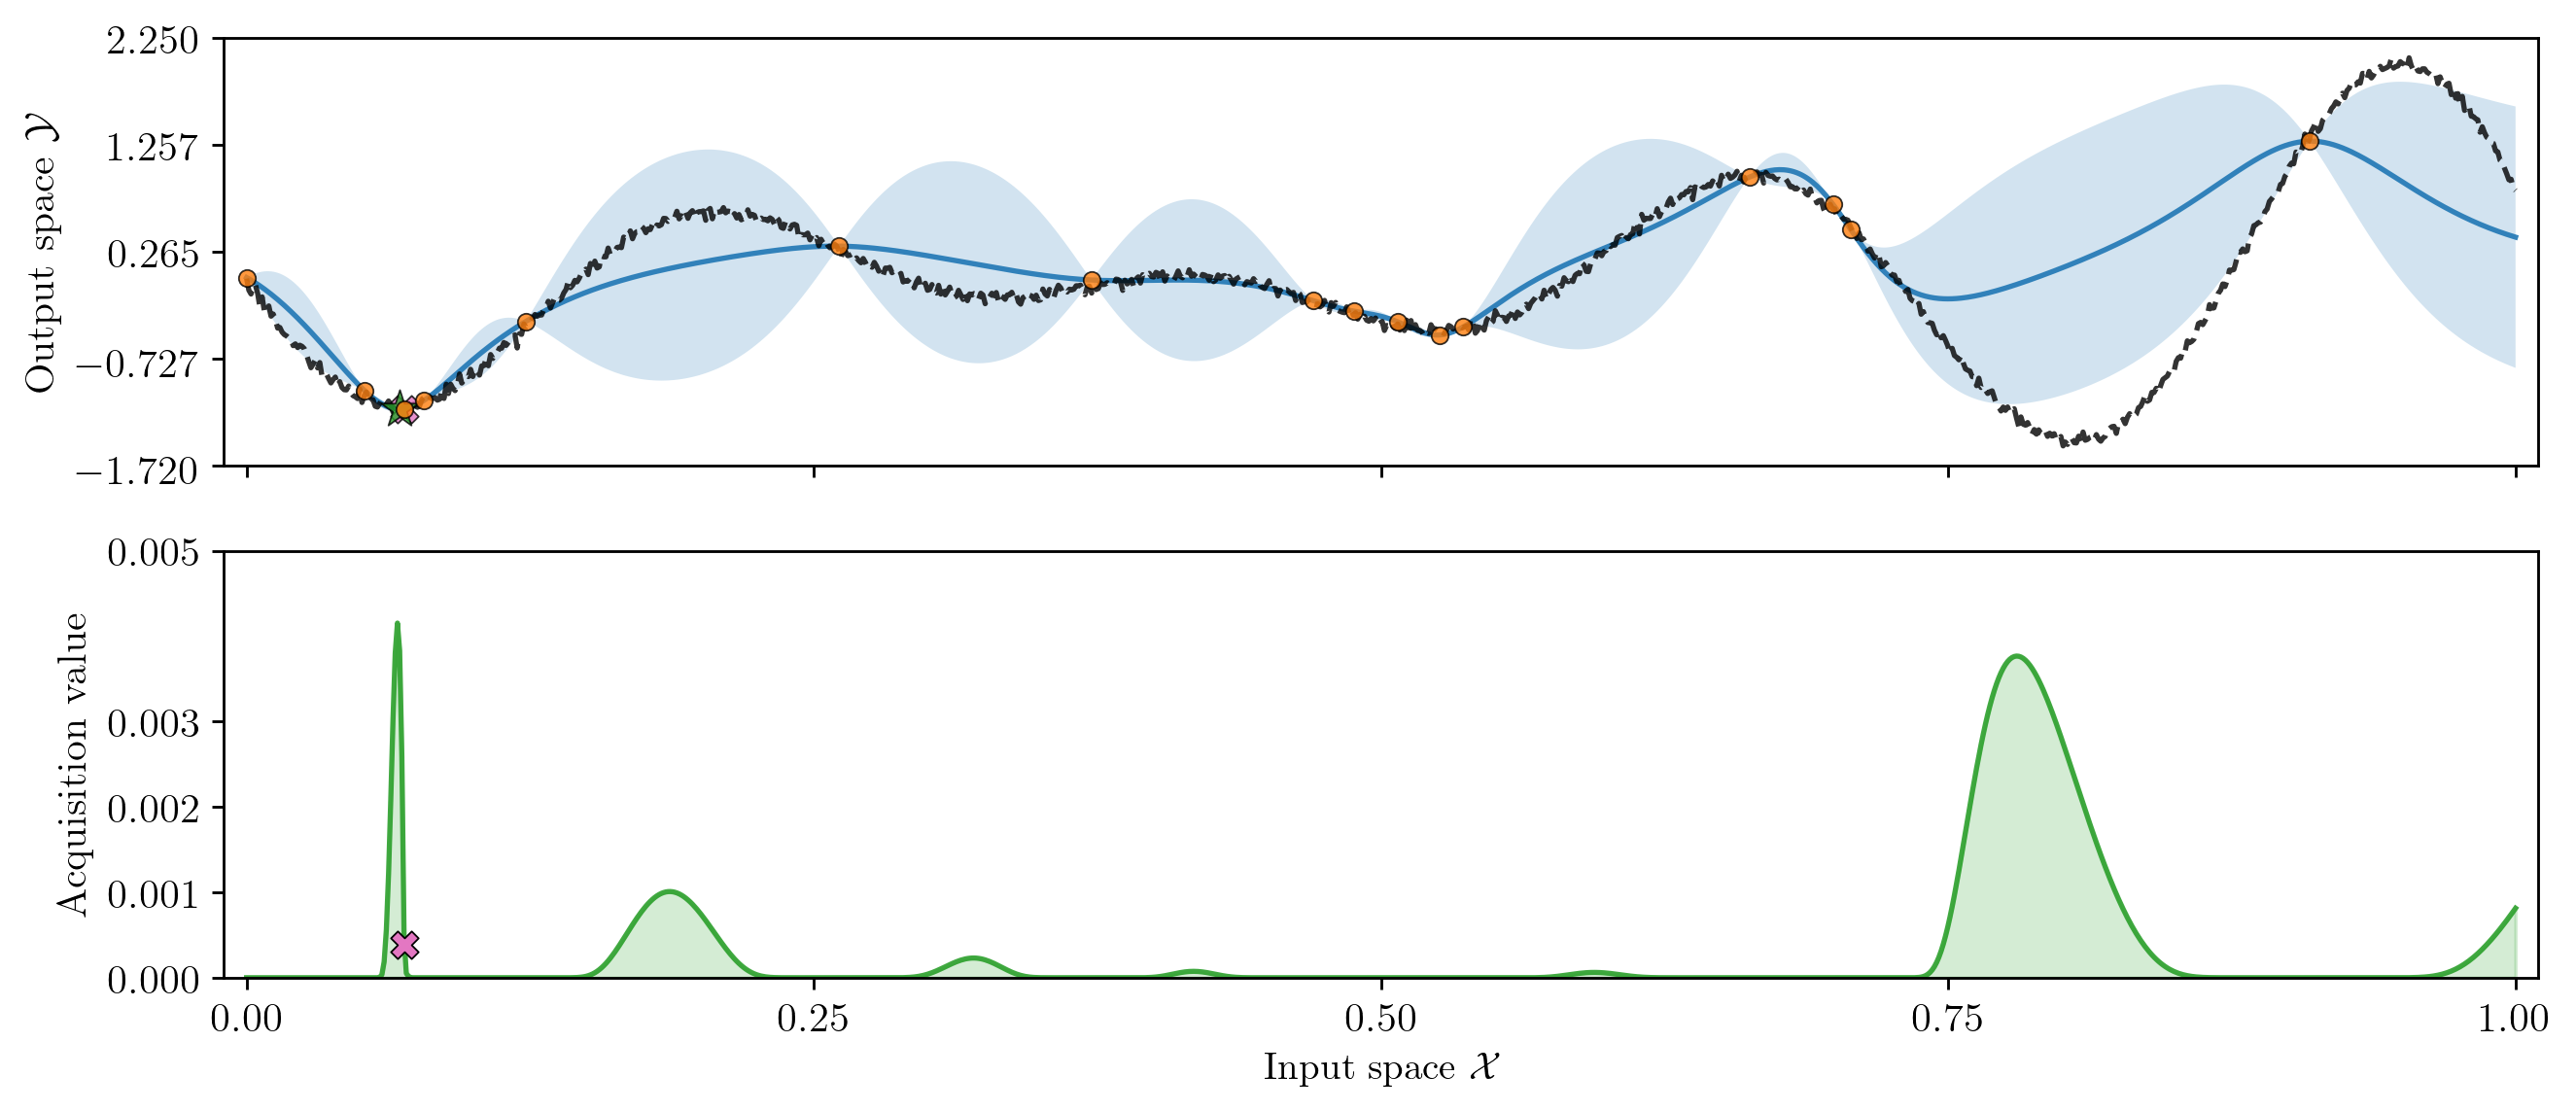

2018-11-27 14:19:28 INFO:run_bayesopt:Finished optimization episode.


In [9]:
# Create initial i/o sequence for optimization episode
inputs_old = rng.rand(3, task.input_dim)
outputs_old = task.numpy(inputs_old)

# Update agent (e.g. fit surrogate model) given initial data
logger.info('Updating search agent')
_ = agent.update(sess, inputs_old, outputs_old)

# Simluate an optimization episode
inputs, outputs = run_simulation(sess, agent, task, inputs_old, outputs_old)